In [1]:
library(ggplot2)
library(dplyr)
library(reshape2)
library(Matrix)
library(gridExtra)

# You may need to set these to your own local paths.
project_directory <- file.path(Sys.getenv("GIT_REPO_LOC"), "MicrocreditLRVB/inst/simulated_data")
raw_data_directory <- file.path(Sys.getenv("GIT_REPO_LOC"), "microcredit_vb/data")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# Read in the data that was produced by the R script.
csv_data <- read.csv(file.path(raw_data_directory, "microcredit_data_processed.csv"))

# The number of distinct groups.
n_g <- max(csv_data$site)

# Get the observations and the total number of observations.
y <- csv_data$profit
y_g <- as.integer(csv_data$site)

# The x array will indicate which rows should also get the
# treatment effect.  The model accomodates generic x, but for
# this application we only need indicators.
x <- cbind(rep(1, length(y)), as.numeric(csv_data$treatment))

data_df <- data.frame(x=x, y=y, y_g=y_g)

data_df_transform <-
  data_df %>%
  mutate(zero_y=abs(y) < 1e-8)

# Note that 1e-8 appears to be a good filter -- we don't have any
# nearly zero entries until ~1e-1, above which they're probably actual nonzero values.
min(abs(filter(data_df_transform, !zero_y)$y))

[1] 0.02063361

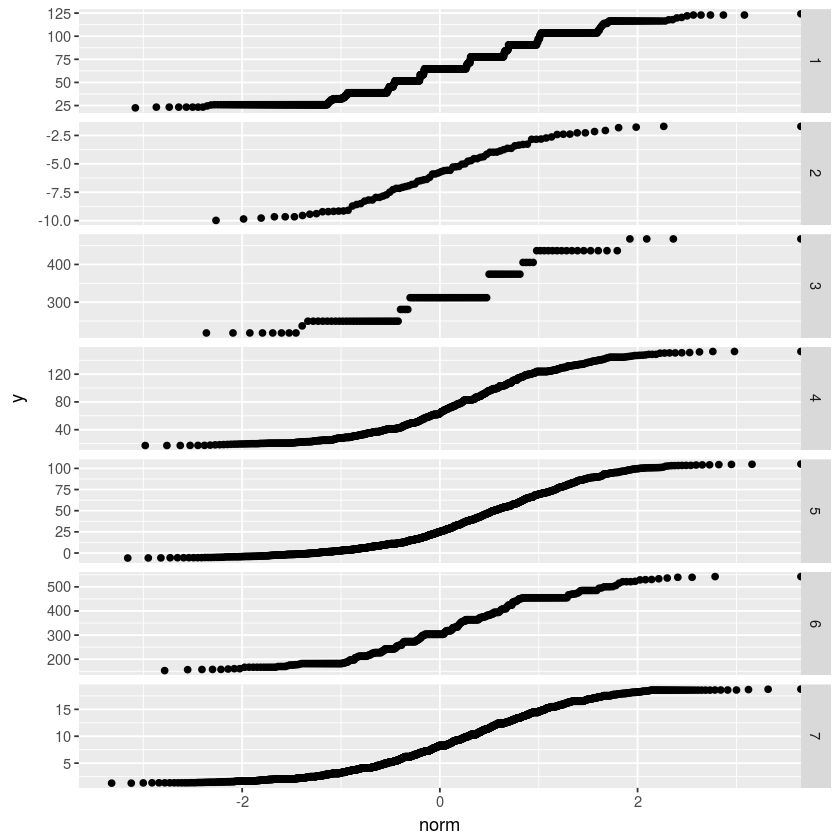

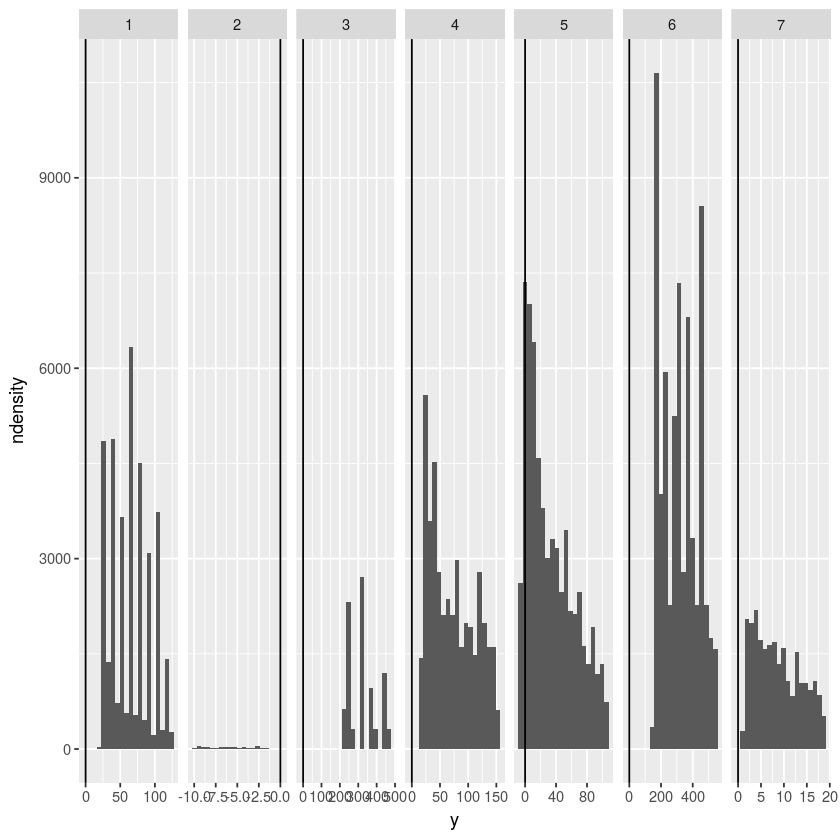

In [4]:
#######################
# Look at qqplots and raw distributions with outlier trimming.  Even after trimming, they do not look very normal.

trim_level <- 0.3
y_quantiles <-
  filter(data_df_transform, !zero_y) %>%
  group_by(y_g) %>%
  summarize(qlower=quantile(y, trim_level), qupper=quantile(y, 1 - trim_level))

data_df_trim <-
  filter(data_df_transform, !zero_y) %>%
  inner_join(y_quantiles, by="y_g") %>%
  filter(y < qupper & y > qlower) %>%
  group_by(y_g) %>%
  arrange(y) %>%
  mutate(q=(1:length(y)) / length(y), norm=qnorm(q))

# Qqplots
ggplot(filter(data_df_trim)) +
  geom_point(aes(x=norm, y=y)) +
  facet_grid(y_g ~ ., scales="free")

ggplot(filter(data_df_trim)) +
  geom_histogram(aes(x=y, y=..ndensity..), bins=20) +
  facet_grid(~ y_g, scales="free") + 
  geom_vline(aes(xintercept=0))




In [ ]:
###################
# Look at cumulative distributions to check for power law behavior.
# If it is a power law, the cumulative distribution will be a straight line
# with slope given by the power law coefficient plus one.

quantile_list <- list()
for (group in 1:max(data_df_transform$y_g)) { for (y_sign in c(-1, 1)) { for (arm in c(0, 1)) {
  rows <- with(data_df_transform, (y_g == group) & (!zero_y) & (y * y_sign > 0) & (x.2 == arm))
  if (sum(rows) > 0) {
    quantile_df <- data.frame(y=sort(y_sign * data_df_transform[rows, ]$y),
                              quantile=(sum(rows):1) / sum(rows),
                              group=group, y_sign=y_sign, arm=arm)
    quantile_list[[length(quantile_list) + 1]] <- quantile_df
  }
}}}
quantile_df <- do.call(rbind, quantile_list)

ggplot(quantile_df) +
    geom_point(aes(x=y_sign * log10(y), y=log10(quantile), color=factor(arm))) +
    facet_grid(group ~ y_sign) +
    ggtitle("Overlaid arms")
ggplot(quantile_df) +
    geom_point(aes(x=log10(y), y=log10(quantile), color=factor(y_sign))) +
    facet_grid(group ~ arm) +
    ggtitle("Overlaid signs")
ggplot(quantile_df) +
    geom_point(aes(x=log10(y), y=log10(quantile), color=paste(arm, y_sign))) +
    facet_grid(group ~ .) +
    ggtitle("Everything overlaid")

In [ ]:
##########################################
# Execute box-cox transforms and save.

# A good reference for the Box-Cox transform:
# https://www.ime.usp.br/~abe/lista/pdfm9cJKUmFZp.pdf
library(MASS)

data_df_transform <-
  data_df %>%
  mutate(zero_y=abs(y) < 1e-8)

# Non-zero values of y_trans will be sent in the loop below.
data_df_transform$y_trans <- 0.0
data_df_transform$lambda <- NaN

for (group in 1:max(y_g)) { for (y_sign in c(-1, 1)) {
  rows <- with(data_df_transform, (y_g == group) & (!zero_y) & (y * y_sign > 0))
  bc_y <- y_sign * data_df_transform[rows, ]$y
  if (length(bc_y) > 0) {
    # The MASS boxcox function is pretty primitive.  Better to do it yourself with optim.
    bc <- boxcox(bc_y ~ 1, plotit=FALSE, lambda=seq(-1, 1, 0.001))
    lambda <- bc$x[which.max(bc$y)]
    if (abs(lambda) < 0.001) {
      lambda <- 0
    }
    if (lambda == 0) {
      y_trans <- log(bc_y)
    } else {
      y_trans <- ((bc_y ^ lambda) - 1) / lambda
    }
    qqnorm(y_trans, main=lambda)
    #readline(prompt="Press [enter] to continue")
    data_df_transform[rows, "y_trans"] <- y_sign * y_trans
    data_df_transform[rows, "lambda"] <- lambda
  }
}}


ggplot(filter(data_df_transform, !zero_y)) +
  geom_histogram(aes(x=y_trans, y=..density..), bins=100) +
  facet_grid(y_g ~ .)

# Look at the lambdas chosen.  They are similar mostly except for group 2.
mutate(data_df_transform, y_pos=y > 0) %>%
  filter(!zero_y) %>%
  group_by(y_g, y_pos) %>%
  summarize(lambda=unique(lambda))